<a href="https://colab.research.google.com/github/Pragna-Teja-Durishetti/BCStasks/blob/main/VeritasVigil_The_truth_Watchmn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

# Load datasets
fake = pd.read_csv('/content/Fake.csv.zip')
true = pd.read_csv('/content/True.csv.zip')

# Add labels
fake['label'] = 0
true['label'] = 1

# Combine and shuffle
df = pd.concat([fake, true]).sample(frac=1, random_state=42).reset_index(drop=True)

# Combine title + text for processing
df['content'] = df['title'] + ' ' + df['text']

data = df.drop(['title','text','subject','date'],axis=1)


data.head()

,label,content
0,0,Ben Stein Calls Out 9th Circuit Court: Committ...
1,1,Trump drops Steve Bannon from National Securit...
2,1,Puerto Rico expects U.S. to lift Jones Act shi...
3,0,OOPS: Trump Just Accidentally Confirmed He Le...
4,1,Donald Trump heads for Scotland to reopen a go...


In [4]:
import re

def custom_tokenizer(text):
    # Lowercase
    text = text.lower()

    # Handle contractions
    contractions = {
        "don't": "do not", "can't": "cannot", "won't": "will not", "i'm": "i am",
        "it's": "it is", "they're": "they are", "we're": "we are", "isn't": "is not"
    }
    for k, v in contractions.items():
        text = text.replace(k, v)

    # Handle emoticons
    emoticons = {r":\)": "", r":\(": "", r":D": ""}
    for k, v in emoticons.items():
        text = re.sub(k, v, text)

    # Normalize repeated characters
    def repeat_replacer(match):
        char = match.group(1)
        count = len(match.group(0))
        return f"{char} "
    text = re.sub(r"(.)\1{2,}", repeat_replacer, text)

    # Split tokens
    tokens = re.findall(r"\w+||||", text)

    return tokens



In [6]:
#This function assigns part-of-speech (POS) tags to a list of tokens
def simple_pos_tagger(tokens):
    pos_tags = []
    for token in tokens:
        if re.match(r".+ing$", token):
            pos_tags.append((token, "VERB"))# Matches words like running, swimming, etc.
        elif re.match(r".+ly$", token):
            pos_tags.append((token, "ADV"))
        elif re.match(r".+ed$", token):
            pos_tags.append((token, "VERB"))
        elif re.match(r".+ous|.+able$", token):
            pos_tags.append((token, "ADJ"))
        elif re.match(r".+ness|.+tion$", token):
            pos_tags.append((token, "NOUN"))
        else:
            pos_tags.append((token, "UNK")) # If none of the above rules match, it assigns the tag "UNK" (unknown)
    return pos_tags

In [7]:

def rule_based_lemmatizer(pos_tagged_tokens):
    lemmas = []
    for word, tag in pos_tagged_tokens:
        if tag == "VERB":
            if word.endswith("ing") or word.endswith("ed"):
                lemma = re.sub(r"(ing|ed)$", "", word)
            else:
                lemma = word
        elif tag == "NOUN" and word.endswith("ness"):
            lemma = word[:-4]
        elif tag == "ADJ" and word.endswith("ful"):
            lemma = word[:-4]
        else:
            lemma = word
        lemmas.append(lemma)
    return lemmas



In [8]:
data['content'] = data['content'].apply(custom_tokenizer)
data['content'] = data['content'].apply(simple_pos_tagger)
data['content'] = data['content'].apply(rule_based_lemmatizer)

In [17]:
from sklearn.model_selection import train_test_split

x= data['content'].astype(str)
y=data['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

In [19]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()# TfidfVectorizer for TF-IDF (Term Frequency–Inverse Document Frequency)
XTfid_train = vectorizer_tfidf.fit_transform(x_train)
XTfid_test = vectorizer_tfidf.transform(x_test)



vectorizer_bow = CountVectorizer() # CountVectorizer for Bag-of-Words
Xbow_train = vectorizer_bow.fit_transform(x_train)
Xbow_test = vectorizer_bow.transform(x_test)

In [23]:
# TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Naive Bayes
nb_tfid = MultinomialNB()
nb_tfid.fit(XTfid_train, y_train)
y_pred_nb_tfid = nb_tfid.predict(XTfid_test)

# SVM
svm_tfid = LinearSVC()
svm_tfid.fit(XTfid_train, y_train)
y_pred_svm_tfid = svm_tfid.predict(XTfid_test)

print("Naive Bayes:\n", classification_report(y_test, y_pred_nb_tfid))
print("SVM:\n", classification_report(y_test, y_pred_svm_tfid))


Naive Bayes:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      4707
           1       0.94      0.92      0.93      4273

    accuracy                           0.94      8980
   macro avg       0.94      0.93      0.94      8980
weighted avg       0.94      0.94      0.94      8980

SVM:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4707
           1       1.00      1.00      1.00      4273

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [24]:
#Bag-of-Words
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Naive Bayes
nb_bow = MultinomialNB()
nb_bow.fit(Xbow_train, y_train)
y_pred_nb_bow = nb_bow.predict(Xbow_test)

# SVM
svm_bow = LinearSVC()
svm_bow.fit(Xbow_train, y_train)
y_pred_svm_bow = svm_bow.predict(Xbow_test)

print("Naive Bayes:\n", classification_report(y_test, y_pred_nb_bow))
print("SVM:\n", classification_report(y_test, y_pred_svm_bow))

Naive Bayes:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      4707
           1       0.95      0.95      0.95      4273

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

SVM:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4707
           1       0.99      1.00      1.00      4273

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


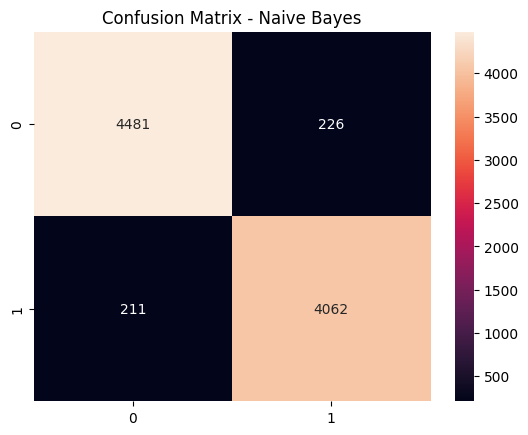

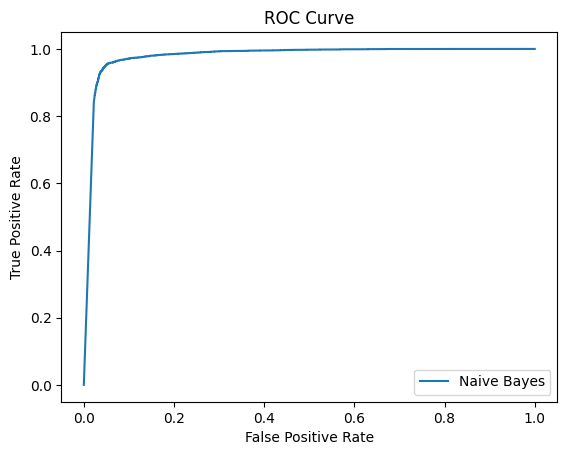

In [28]:
#for Naive bayes with Bag Of Words vectorization
import seaborn as sns


# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_nb_bow), annot=True, fmt='d')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, nb_bow.predict_proba(Xbow_test)[:,1])
plt.plot(fpr, tpr, label="Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


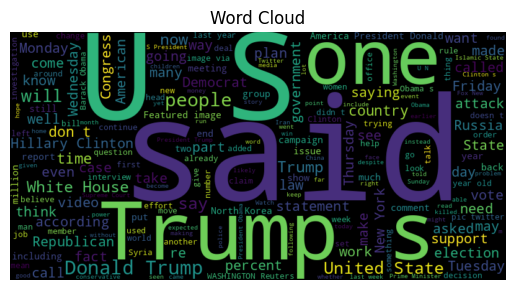

In [27]:
from wordcloud import WordCloud
import seaborn as sns

# WordCloud
text = " ".join(df['content'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()
